# CMIP6 Historical model runs
- opens all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas
- calculates monthly anomalies (based on 1850-1880 climatology) for 4 spatial regions (global, SH, Aus, E Aus)
- calculates percentiles (10, 90) to show model spread
- plots a time series of tas and pr results from 1850-2015

In [4]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [5]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [6]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [7]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [8]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [9]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [10]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [11]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [12]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [13]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [14]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [15]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [16]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

## Anomalies

In [17]:
# use functions to calculate the monthly anomalies for the globe
monthly_anom_glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [18]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(-90,0)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(0,90)) 

In [19]:
# select out the Australian and E Australian anomalies 
monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Multi-model mean

In [20]:
# take lat lon mean
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [21]:
# Take the multimodel mean for each region
mmm_mon_Glob = monthly_anom_glob.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_SH = monthly_anom_SH.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_NH = monthly_anom_NH.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_Aus = monthly_anom_Aus.mean(dim='model').mean(dim=['lat','lon'])
mmm_mon_EA = monthly_anom_EA.mean(dim='model').mean(dim=['lat','lon'])

## Percentiles 

In [22]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_SH = llm_SH.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_NH = llm_NH.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_Aus = llm_Aus.chunk({'model': -1}).quantile(0.1, dim=['model'])
p10_mon_EA = llm_EA.chunk({'model': -1}).quantile(0.1, dim=['model'])

In [23]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_SH = llm_SH.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_NH = llm_NH.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_Aus = llm_Aus.chunk({'model': -1}).quantile(0.9, dim=['model'])
p90_mon_EA = llm_EA.chunk({'model': -1}).quantile(0.9, dim=['model'])

## Figures

In [24]:
func2 = reload(func2)

In [25]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

[########################################] | 100% Completed |  7min 31.8s
[########################################] | 100% Completed |  7min 20.2s
[########################################] | 100% Completed |  9min 50.1s
[########################################] | 100% Completed |  9min  0.4s
[########################################] | 100% Completed |  9min 11.0s
[########################################] | 100% Completed |  9min 42.4s
[########################################] | 100% Completed | 10min 51.9s
[########################################] | 100% Completed | 11min 16.2s
[#########                               ] | 24% Completed |  2min 44.4s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  9min 43.5s
[########################################] | 100% Completed |  9min 25.0s
[########################################] | 100% Completed |  8min 18.0s
[#########                               ] | 24% Completed |  2min 10.9s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  7min 25.1s


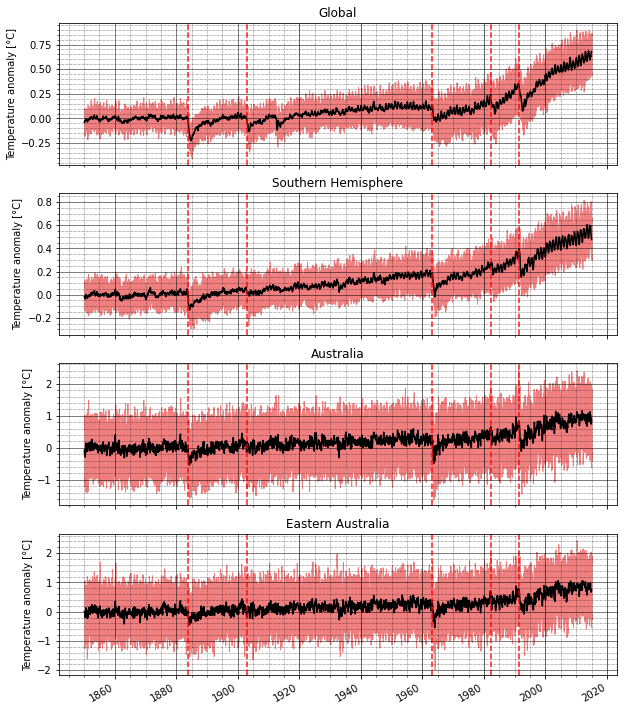

In [26]:

# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    func2.timeseries_graph(mmm_mon_Glob.tas, p10_mon_Glob.tas, p90_mon_Glob.tas, ax = axes[0], color='lightcoral')
    func2.timeseries_graph(mmm_mon_SH.tas, p10_mon_SH.tas, p90_mon_SH.tas, ax = axes[1], color='lightcoral')
    func2.timeseries_graph(mmm_mon_Aus.tas, p10_mon_Aus.tas, p90_mon_Aus.tas, ax = axes[2], color='lightcoral')
    func2.timeseries_graph(mmm_mon_EA.tas, p10_mon_EA.tas, p90_mon_EA.tas, ax = axes[3], color='lightcoral')

axes[0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('timeseries_mon_tas_stacked.png', dpi=300, bbox_inches='tight')

In [27]:
func2 = reload(func2)

[########################################] | 100% Completed |  6min 54.1s
[########################################] | 100% Completed |  6min 37.2s
[########################################] | 100% Completed |  7min  9.3s
[########################################] | 100% Completed |  6min 18.7s
[########################################] | 100% Completed |  6min 16.1s
[########################################] | 100% Completed |  6min 44.4s
[########################################] | 100% Completed |  8min 10.4s
[########################################] | 100% Completed |  8min 19.5s
[#########                               ] | 24% Completed |  2min  8.7s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  7min 29.1s
[########################################] | 100% Completed |  8min 12.5s
[########################################] | 100% Completed |  8min 16.0s
[#########                               ] | 24% Completed |  2min 12.0s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  7min 35.2s


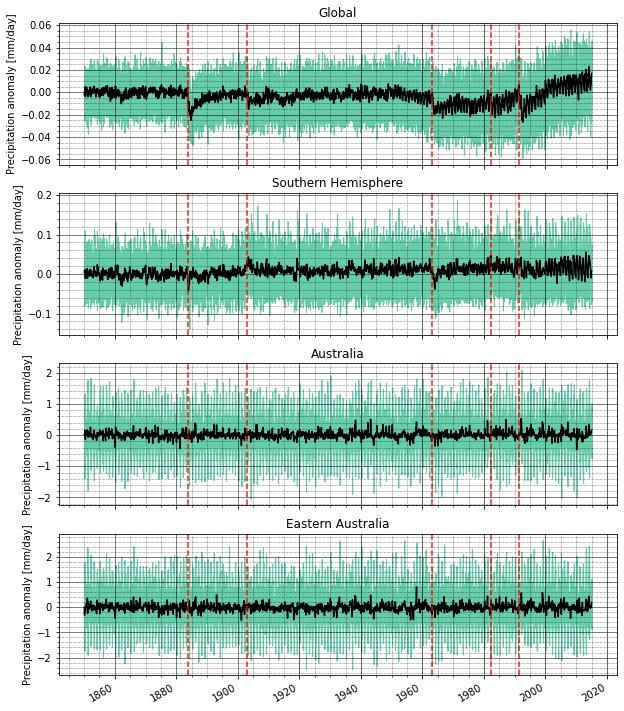

In [28]:
# same plot but stacked rather than 2x2
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    func2.timeseries_graph(mmm_mon_Glob.pr, p10_mon_Glob.pr, p90_mon_Glob.pr, ax = axes[0], color='mediumaquamarine')
    func2.timeseries_graph(mmm_mon_SH.pr, p10_mon_SH.pr, p90_mon_SH.pr, ax = axes[1], color='mediumaquamarine')
    func2.timeseries_graph(mmm_mon_Aus.pr, p10_mon_Aus.pr, p90_mon_Aus.pr, ax = axes[2], color='mediumaquamarine')
    func2.timeseries_graph(mmm_mon_EA.pr, p10_mon_EA.pr, p90_mon_EA.pr, ax = axes[3], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of precipitation anomalies', size=16)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('timeseries_mon_pr_stacked.png', dpi=300, bbox_inches='tight')


In [29]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [32]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [33]:
# Zoom in on Krakatoa time period
K_mmm_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob = p10_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH = p10_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus = p10_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA = p10_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob = p90_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH = p90_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus = p90_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA = p90_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [34]:
func2 = reload(func2)

In [35]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

# x ticks are not quite working properly
# might need to zoom in on just 5 years 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


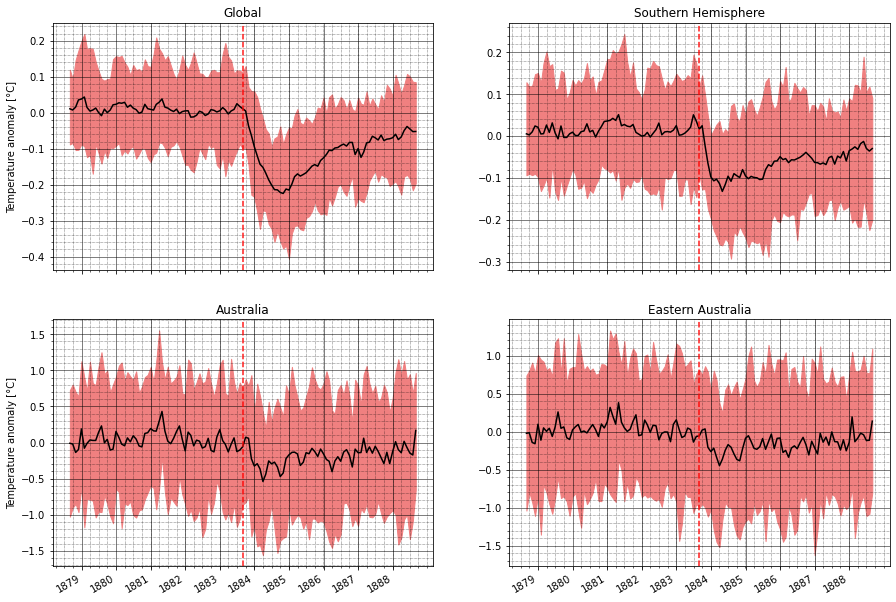

In [36]:
# Monthly temperature anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
func2.timeseries_graph(K_mmm_Glob.tas, K_p10_Glob.tas, K_p90_Glob.tas, ax = axes[0,0],color='lightcoral')
func2.timeseries_graph(K_mmm_SH.tas, K_p10_SH.tas, K_p90_SH.tas, ax = axes[0,1], color='lightcoral')
func2.timeseries_graph(K_mmm_Aus.tas, K_p10_Aus.tas, K_p90_Aus.tas, ax = axes[1,0], color='lightcoral')
func2.timeseries_graph(K_mmm_EA.tas, K_p10_EA.tas, K_p90_EA.tas, ax = axes[1,1], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

#fig.suptitle('10-year time series of temperature anomalies', size=16)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('K_timeseries_mon_tas.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


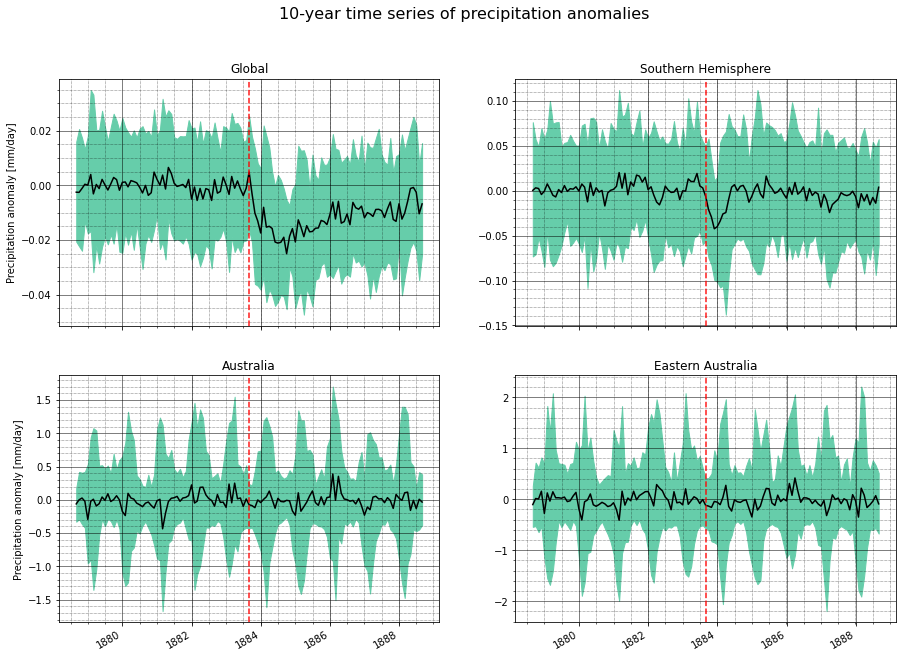

In [37]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
func2.timeseries_graph(K_mmm_Glob.pr, K_p10_Glob.pr, K_p90_Glob.pr, ax = axes[0,0], color='mediumaquamarine')
func2.timeseries_graph(K_mmm_SH.pr, K_p10_SH.pr, K_p90_SH.pr, ax = axes[0,1], color='mediumaquamarine')
func2.timeseries_graph(K_mmm_Aus.pr, K_p10_Aus.pr, K_p90_Aus.pr, ax = axes[1,0], color='mediumaquamarine')
func2.timeseries_graph(K_mmm_EA.pr, K_p10_EA.pr, K_p90_EA.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel='Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel='Precipitation anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set's the axis ticks 12 months apart
#axes[0,0].set_xticks((min(K_mmm_mon_Glob.time).data, max(K_mmm_mon_Glob.time).data), 3)

fig.suptitle('10-year time series of precipitation anomalies', size=16)

plt.savefig('K_timeseries_mon_pr.png', dpi=300, bbox_inches='tight')